In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,AveragePooling2D,AveragePooling3D
from keras.layers import Dense, GlobalAveragePooling3D,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
from keras.optimizers import SGD, RMSprop, Adadelta
from keras.utils import np_utils, generic_utils, Sequence
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional_recurrent import ConvLSTM2D
import keras

import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
# image specification
img_cols,img_rows=100,176
nb_frames = 64    # img_depth or number of frames used for each video
# CNN Training parameters
nb_classes = 27
channels = 2

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# integer encode
labels = pd.read_csv('E:\Jupyter\Project\jester-v1-labels.csv',sep=';',header=None,names=['Class'])     # reading the csv file
label_encoder = LabelEncoder()
labels['Label'] = label_encoder.fit_transform(labels['Class'])

#train
train = pd.read_csv('E:\Jupyter\Project\jester-v1-train.csv',sep=';',header=None,names=['Video','Class'])     # reading the csv file
train['Label'] = label_encoder.fit_transform(train['Class'])

#validation
validation = pd.read_csv('E:\Jupyter\Project\jester-v1-validation.csv',sep=';',header=None,names=['Video','Class'])     # reading the csv file
validation['Label'] = label_encoder.fit_transform(validation['Class'])

#test
#test = pd.read_csv('E:\Jupyter\Project\jester-v1-test.csv',sep=';',header=None,names=['Video'])     # reading the csv file

#print labels
#labels
"""
partition_dict = {
    "train": train["Video"].tolist(),
    "validation": validation["Video"].tolist()
}"""
temp = pd.concat([train, validation])
temp = temp.set_index("Video")
#temp = train.set_index("Video")
temp.transpose()
labels_dict = temp["Label"].to_dict()
len(train)

118562

In [4]:
#train
train = train[train["Class"].isin(["No gesture","Swiping Left","Swiping Right","Stop Sign","Rolling Hand Forward","Rolling Hand Backward"])]
train['Label'] = label_encoder.fit_transform(train['Class'])

#validation
validation = validation[validation["Class"].isin(["No gesture","Swiping Left","Swiping Right","Stop Sign","Rolling Hand Forward","Rolling Hand Backward"])]
validation['Label'] = label_encoder.fit_transform(validation['Class'])

#test
#test = pd.read_csv('E:\Jupyter\Project\jester-v1-test.csv',sep=';',header=None,names=['Video'])     # reading the csv file

#print labels
#labels
"""
partition_dict = {
    "train": train["Video"].tolist(),
    "validation": validation["Video"].tolist()
}"""
temp = pd.concat([train, validation])
temp = temp.set_index("Video")
#temp = train.set_index("Video")
temp.transpose()
labels_dict = {}
labels_dict = temp["Label"].to_dict()
len(train)

25025

In [5]:
import random
def data_gen(train_list, batch_size=64):
    while True:
        X_tr=[]
        label=[]
        for vid_ID in random.sample(train_list,batch_size):
            frames = []
            frame_count=0
            pos_dir = os.path.join("E:/Jupyter/Project/generated_images_timeSampled/pos",str(vid_ID))
            neg_dir = os.path.join("E:/Jupyter/Project/generated_images_timeSampled/neg",str(vid_ID))
            for img_ID in sorted(os.listdir(pos_dir)):
                if frame_count < nb_frames:
                    pos = os.path.join(pos_dir,img_ID)
                    neg = os.path.join(neg_dir,img_ID)
                    p_img = cv2.imread(pos,0)
                    p_img = cv2.resize(p_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
                    n_img = cv2.imread(neg,0)
                    n_img = cv2.resize(n_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
                    frame = cv2.merge((p_img,n_img))
                    frames.append(frame)
                    frame_count+=1
                else:
                    break
            while frame_count < nb_frames:
                frames.append(np.zeros((img_cols,img_rows,channels), np.uint8))
                frame_count+=1
            input_img = np.array(frames)
            ipt=np.rollaxis(np.rollaxis(input_img,2,0),2,0)
            ipt=np.rollaxis(ipt,2,0)
            X_tr.append(ipt)
            label.append(labels_dict[vid_ID])

        X_tr_array = np.array(X_tr)   # convert the frames read into array

        Y_train = np_utils.to_categorical(label, nb_classes)

        yield X_tr_array,Y_train

In [6]:
print(next(data_gen(train["Video"].tolist()))[0].shape)

(64, 64, 100, 176, 2)


In [8]:
# Define model
import tensorflow as tf
keras=tf.contrib.keras
l2=keras.regularizers.l2
weight_decay = 0.00005
from keras import regularizers

model = Sequential()

model.add(MaxPooling3D(pool_size=(1, 2, 2),input_shape=(nb_frames,  img_cols, img_rows, channels)))

model.add(Conv3D(16,(3,3,3),
                        input_shape=(nb_frames, img_cols, img_rows, channels),
                        activation='relu'))
model.add(Conv3D(16,(3,3,3), strides=(2,2,2),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_1', activation = 'relu'))
model.add(Conv3D(4,(4,4,4), strides=(2,2,2),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_2', activation = 'relu'))
model.add(Conv3D(4,(1,1,1), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_3', activation = 'relu'))
model.add(Conv3D(4,(2,2,2), strides=(2,2,2),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_4', activation = 'relu'))
model.add(Conv3D(64,(3,3,3), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_5', activation = 'relu'))
model.add(Conv3D(8,(1,1,1), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_6', activation = 'relu'))
model.add(Conv3D(8,(1,1,1), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_7', activation = 'relu'))
model.add(Conv3D(8,(1,1,1), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_8', activation = 'relu'))
model.add(Conv3D(32,(2,2,2), strides=(2,2,2),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_9', activation = 'relu'))
model.add(Conv3D(128,(3,3,3), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_10', activation = 'relu'))
model.add(Conv3D(16,(1,1,1), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_11', activation = 'relu'))
model.add(Conv3D(16,(1,1,1), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_12', activation = 'relu'))
model.add(Conv3D(64,(2,2,2), strides=(2,2,2),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_13', activation = 'relu'))
model.add(Conv3D(16,(1,1,1), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_14', activation = 'relu'))
model.add(Conv3D(16,(1,1,1), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_15', activation = 'relu'))
model.add(ConvLSTM2D(filters=64, kernel_size=(3,3),
                  strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(weight_decay),
                      return_sequences=True, name='gatedclstm1'))

model.add(ConvLSTM2D(filters=64, kernel_size=(3,3),
                  strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(weight_decay),
                      return_sequences=True, name='gatedclstm2'))

model.add(ConvLSTM2D(filters=64, kernel_size=(3,3),
                  strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(weight_decay),
                      return_sequences=True, name='gatedclstm3'))


model.add(Flatten())
model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))

model.add(Dense(nb_classes,kernel_initializer='normal',kernel_regularizer=regularizers.l2(weight_decay)))

model.add(Activation('softmax'))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling3d_2 (MaxPooling3 (None, 64, 50, 88, 2)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 62, 48, 86, 16)    880       
_________________________________________________________________
Conv3D_1 (Conv3D)            (None, 31, 24, 43, 16)    6912      
_________________________________________________________________
Conv3D_2 (Conv3D)            (None, 16, 12, 22, 4)     4096      
_________________________________________________________________
Conv3D_3 (Conv3D)            (None, 16, 12, 22, 4)     16        
_________________________________________________________________
Conv3D_4 (Conv3D)            (None, 8, 6, 11, 4)       128       
_________________________________________________________________
Conv3D_5 (Conv3D)            (None, 8, 6, 11, 64)      6912      
__________

In [10]:
import os
save_dir = os.path.join(os.getcwd(),'save_model')
print(os.getcwd())
model_name = "deep"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor = 'val_acc', 
                            save_best_only=True, verbose=1)
#earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=50, verbose =1)

E:\Jupyter\Project


In [11]:
sgd = SGD(lr=0.002,  momentum=0.9, nesterov=False)
rms = RMSprop(decay=1e-6)
ada = Adadelta(lr=0.1,decay=1e-6)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              #optimizer=ada,
              #optimizer = Adam(lr=0.0001),
              metrics=['acc'])

In [12]:
nb_epoch = 100
batch_size = 32
#steps_per_epoch=int((len(X_val_new)*1.5)/batch_size)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.05, 
                               cooldown=0, patience=10, min_lr=0.005/(2^4),verbose=1)
hist = model.fit_generator(data_gen(train["Video"].tolist()[0:],batch_size),
                           validation_data=data_gen(validation["Video"].tolist()[0:],batch_size),
                           steps_per_epoch=len(train["Video"].tolist()[0:])//(16*batch_size),
                           validation_steps=len(validation["Video"].tolist()[0:])//(32*batch_size),
                           epochs = nb_epoch,
                           callbacks=[checkpoint,lr_reducer]
                          )

Epoch 1/100
48/48 [==============================] - 180s 4s/step - loss: 3.4677 - acc: 0.1445 - val_loss: 3.3662 - val_acc: 0.0781

Epoch 00001: val_acc improved from -inf to 0.07812, saving model to E:\Jupyter\Project\save_model\deep
Epoch 2/100
48/48 [==============================] - 146s 3s/step - loss: 3.2414 - acc: 0.1842 - val_loss: 3.0846 - val_acc: 0.1250

Epoch 00002: val_acc improved from 0.07812 to 0.12500, saving model to E:\Jupyter\Project\save_model\deep
Epoch 3/100
48/48 [==============================] - 149s 3s/step - loss: 2.7866 - acc: 0.1725 - val_loss: 2.4326 - val_acc: 0.1406

Epoch 00003: val_acc improved from 0.12500 to 0.14062, saving model to E:\Jupyter\Project\save_model\deep
Epoch 4/100
48/48 [==============================] - 128s 3s/step - loss: 2.2689 - acc: 0.1497 - val_loss: 2.0330 - val_acc: 0.2188

Epoch 00004: val_acc improved from 0.14062 to 0.21875, saving model to E:\Jupyter\Project\save_model\deep
Epoch 5/100
48/48 [============================

48/48 [==============================] - 114s 2s/step - loss: 1.1748 - acc: 0.5879 - val_loss: 1.1912 - val_acc: 0.7344

Epoch 00042: val_acc improved from 0.60938 to 0.73438, saving model to E:\Jupyter\Project\save_model\deep
Epoch 43/100
48/48 [==============================] - 118s 2s/step - loss: 1.1700 - acc: 0.5911 - val_loss: 1.0704 - val_acc: 0.6719

Epoch 00043: val_acc did not improve from 0.73438
Epoch 44/100
48/48 [==============================] - 116s 2s/step - loss: 1.1677 - acc: 0.5755 - val_loss: 1.1076 - val_acc: 0.6562

Epoch 00044: val_acc did not improve from 0.73438
Epoch 45/100
48/48 [==============================] - 114s 2s/step - loss: 1.1466 - acc: 0.5781 - val_loss: 1.0521 - val_acc: 0.5625

Epoch 00045: val_acc did not improve from 0.73438
Epoch 46/100
48/48 [==============================] - 117s 2s/step - loss: 1.1804 - acc: 0.5814 - val_loss: 1.2817 - val_acc: 0.5938

Epoch 00046: val_acc did not improve from 0.73438
Epoch 47/100
48/48 [=================

48/48 [==============================] - 117s 2s/step - loss: 0.8990 - acc: 0.7194 - val_loss: 1.1665 - val_acc: 0.6875

Epoch 00085: val_acc did not improve from 0.79688
Epoch 86/100
48/48 [==============================] - 116s 2s/step - loss: 0.8950 - acc: 0.7090 - val_loss: 0.9275 - val_acc: 0.6406

Epoch 00086: val_acc did not improve from 0.79688
Epoch 87/100
48/48 [==============================] - 116s 2s/step - loss: 0.9012 - acc: 0.7025 - val_loss: 0.8269 - val_acc: 0.7344

Epoch 00087: val_acc did not improve from 0.79688

Epoch 00087: ReduceLROnPlateau reducing learning rate to 0.0008333333333333334.
Epoch 88/100
48/48 [==============================] - 119s 2s/step - loss: 0.8755 - acc: 0.7096 - val_loss: 0.8156 - val_acc: 0.7812

Epoch 00088: val_acc did not improve from 0.79688
Epoch 89/100
48/48 [==============================] - 116s 2s/step - loss: 0.9010 - acc: 0.7148 - val_loss: 0.8386 - val_acc: 0.7969

Epoch 00089: val_acc did not improve from 0.79688
Epoch 90/100

In [13]:
training_loss = hist.history['loss']
val_loss = hist.history['val_loss']
training_acc = hist.history['acc']
val_acc = hist.history['val_acc']

In [14]:
"""for entry in hist1.history['loss']:
    training_loss.append(entry)
for entry in hist1.history['val_loss']:
    val_loss.append(entry)
for entry in hist1.history['acc']:
    training_acc.append(entry)
for entry in hist1.history['val_acc']:
    val_acc.append(entry)"""

100
100
100
100


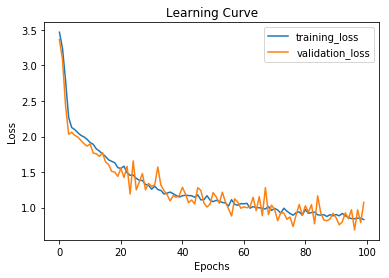

"with open('deeploss_tr.pkl','rb') as fid:\n    training_loss = pickle.load(fid)"

In [15]:
import pickle
plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

with open('E:/Jupyter/Project/save_model/deeploss_tr.pkl','wb') as fid:
    pickle.dump(training_loss, fid)
with open('E:/Jupyter/Project/save_model/deeploss_val.pkl','wb') as fid:
    pickle.dump(val_loss, fid)
"""with open('deeploss_tr.pkl','rb') as fid:
    training_loss = pickle.load(fid)"""

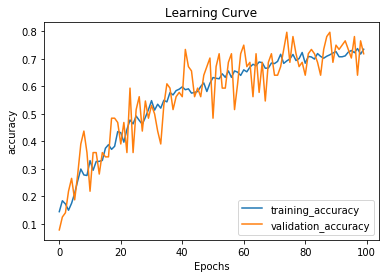

In [ ]:

plt.plot(training_acc, label="training_accuracy")
plt.plot(val_acc, label="validation_accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

with open('E:/Jupyter/Project/save_model/deepacc_tr.pkl','wb') as fid:
    pickle.dump(training_acc, fid)
with open('E:/Jupyter/Project/save_model/deepacc_val.pkl','wb') as fid:
    pickle.dump(val_acc, fid)

In [ ]:
from keras.models import Model, load_model
model1_name = "deep"
model1_path = os.path.join(save_dir, model1_name)
model1 = load_model(model1_path)

In [ ]:
# Training data

X_tr=[]           # variable to store entire dataset
label=[]

from tqdm import tqdm

ls_path = os.path.join("E:/Jupyter/Project/generated_images_timeSampled")

for vid_ID in tqdm(validation["Video"].tolist()[0:1500]):
    frames = []
    frame_count=0
    pos_dir = os.path.join(os.path.join(ls_path,"pos"),str(vid_ID))
    neg_dir = os.path.join(os.path.join(ls_path,"pos"),str(vid_ID))
    for img_ID in sorted(os.listdir(pos_dir)):
        if frame_count < nb_frames:
            pos = os.path.join(pos_dir,img_ID)
            neg = os.path.join(neg_dir,img_ID)
            p_img = cv2.imread(pos,0)
            p_img = cv2.resize(p_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
            n_img = cv2.imread(neg,0)
            n_img = cv2.resize(n_img,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
            frame = cv2.merge((p_img,n_img))
            frames.append(frame)
            frame_count+=1
        else:
            break
    while frame_count < nb_frames:
        frames.append(np.zeros((img_cols,img_rows,channels), np.uint8))
        frame_count+=1
    input_img = np.array(frames)
    ipt=np.rollaxis(np.rollaxis(input_img,2,0),2,0)
    ipt=np.rollaxis(ipt,2,0)
    X_tr.append(ipt)
    label.append(labels_dict[vid_ID])

print (ipt.shape)
num_samples = len(X_tr) 
print (num_samples)
X_tr_array = np.array(X_tr)   # convert the frames read into array

train_data = [X_tr_array,label]
(X_train, y_train) = (train_data[0],train_data[1])
train_set = np.zeros((num_samples, nb_frames, img_cols,img_rows,2))
for h in range(num_samples):
    train_set[h][:][:][:][:]=X_train[h,:,:,:]
Y_train = np_utils.to_categorical(y_train, nb_classes)

100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:39<00:00, 15.08it/s]


(64, 100, 176, 2)
1500


In [ ]:
test_pred =model1.predict(train_set[50:70])
result = np.argmax(test_pred, axis =1)
print(result)

In [ ]:
img_array = train_set[50]
from sklearn.metrics import confusion_matrix
met = confusion_matrix(np.argmax(Y_train,axis =1), np.argmax(model1.predict(train_set),axis =1))
print(met)

In [ ]:
import itertools
def confusion_matrix_plot(cm, classes, 
                          title='Normalized Confusion Matrix', 
                          normalize=True, 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    plt.subplots(1, 1, figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
confusion_matrix_plot(met, classes=labels[labels["Class"].isin(["No gesture","Swiping Left","Swiping Right","Stop Sign","Rolling Hand Forward","Rolling Hand Backward"])].sort_values(by=['Label'])['Class'].tolist())

In [ ]:
model1.evaluate(train_set,Y_train)

In [ ]:
model.evaluate(train_set,Y_train)

In [ ]:
nb_epoch = 100
batch_size = 32
#steps_per_epoch=int((len(X_val_new)*1.5)/batch_size)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.05, 
                               cooldown=0, patience=10, min_lr=0.005/(2^4),verbose=1)
hist1 = model.fit_generator(data_gen(train["Video"].tolist()[0:],batch_size),
                           validation_data=data_gen(validation["Video"].tolist()[0:],batch_size),
                           steps_per_epoch=len(train["Video"].tolist()[0:])//(16*batch_size),
                           validation_steps=len(validation["Video"].tolist()[0:])//(32*batch_size),
                           epochs = nb_epoch,
                           callbacks=[checkpoint,lr_reducer]
                          )

In [ ]:
for entry in hist1.history['loss']:
    training_loss.append(entry)
for entry in hist1.history['val_loss']:
    val_loss.append(entry)
for entry in hist1.history['acc']:
    training_acc.append(entry)
for entry in hist1.history['val_acc']:
    val_acc.append(entry)

In [ ]:
plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [ ]:
plt.plot(training_acc, label="training_accuracy")
plt.plot(val_acc, label="validation_accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [ ]:
img_array = train_set[50]
from sklearn.metrics import confusion_matrix
met = confusion_matrix(np.argmax(Y_train,axis =1), np.argmax(model1.predict(train_set),axis =1))
print(met)

In [ ]:
confusion_matrix_plot(met, classes=labels[labels["Class"].isin(["No gesture","Swiping Left","Swiping Right","Stop Sign","Rolling Hand Forward","Rolling Hand Backward"])].sort_values(by=['Label'])['Class'].tolist())

In [ ]:
model1.evaluate(train_set,Y_train)

In [ ]:
model.evaluate(train_set,Y_train)